# This is the method that will work in this code.


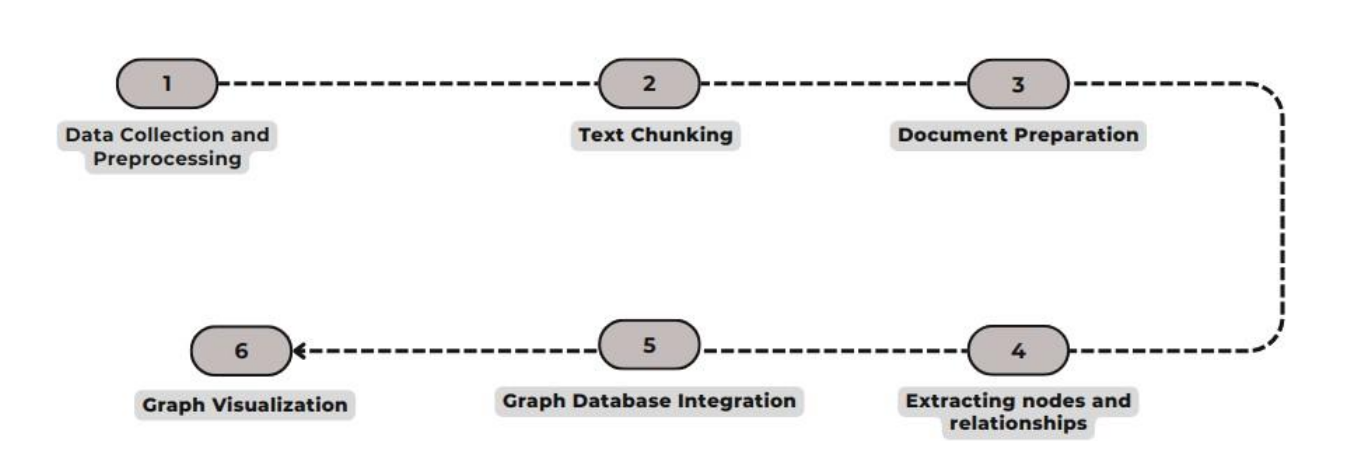

# Install all required libraries

In [ ]:
%pip install pandas base64 google-cloud-storage google-generativeai langchain-google-genai beautifulsoup4 requests regex pdfplumber langchain-community langchain-experimental yfiles-jupyter-graphs neo4j google-colab langchain-ollama langchain-openai

In [1]:
import os
import re
import base64
import requests
import pandas as pd
import pdfplumber
from getpass import getpass
from bs4 import BeautifulSoup
from google.cloud import storage
import google.generativeai as genai
import vertexai
from vertexai.preview.generative_models import (
    GenerativeModel, SafetySetting, Part, Tool, grounding
)
from langchain_google_genai import GoogleGenerativeAI, ChatGoogleGenerativeAI
from langchain.document_loaders import WikipediaLoader
from langchain.docstore.document import Document
from langchain_text_splitters import TokenTextSplitter
from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

# LLM Initialization


In [ ]:
#If your LLM is Gemini, then use the following code
from getpass import getpass

api_key = getpass()
llm = GoogleGenerativeAI(model="gemini-pro", google_api_key=api_key)

In [ ]:
#If your LLM is a local llm, then use the following code with ollama 
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="llama3.1:8b")

In [ ]:
#If your LLM is OpenAI, then use the following code
import getpass
from langchain_openai import OpenAI
import os


OPENAI_ORGANIZATION = getpass.getpass("Enter your OPENAI_ORGANIZATION: ")
os.environ["OPENAI_ORGANIZATION"] = OPENAI_ORGANIZATION
llm = OpenAI()

# Set up Neo4j connection credentials

In [ ]:
NEO4J_URI="YOUR_NEO4J_URI"
NEO4J_USERNAME="YOUR_NEO4J_USERNAME"
NEO4J_PASSWORD="YOUR_NEO4J_PASSWORD"
AURA_INSTANCEID="YOUR_AURA_INSTANCEID"
AURA_INSTANCENAME="YOUR_AURA_INSTANCENAME"

In [ ]:
os.environ["NEO4J_URI"] = NEO4J_URI
os.environ["NEO4J_USERNAME"] = NEO4J_USERNAME
os.environ["NEO4J_PASSWORD"] = NEO4J_PASSWORD

# Web Scraping

In [ ]:
# Change your url acording to url will use
url = "https://www.tram-pietonnisation.fr/info-travaux/"
response = requests.get(url)


soup = BeautifulSoup(response.text, 'html.parser')
tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'table', 'ul', 'ol']

    # Variable to store all extracted text
all_text = ""
elements = soup.find_all(tags)

for element in elements:
      if element.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
          all_text += f"{element.text.strip()}\n"
      elif element.name == 'p':
          all_text += f"{element.text.strip()}\n"
          for li in element.find_all('li'):
               all_text += f"- {li.text.strip()}\n"
      elif element.name == 'table':
          rows = element.find_all('tr')
          for row in rows:
              cells = row.find_all(['th', 'td'])
              all_text += "\t".join(cell.text.strip() for cell in cells) + "\n"

print(all_text)

In [ ]:
#if you saw a word not nescary you cany use this code to delete it
stop_text = "D'autres projets à découvrir"

if stop_text in all_text:
    all_text = all_text.split(stop_text)[0].strip()

# Or extract texts from pdfs

In [ ]:
import pdfplumber

# Load the PDF file and extract text
pdf_path = "/content/di_lex_final-17122018-web_0.pdf"
all_text = ""

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        all_text += page.extract_text() + "\n"

# Displaying the first part of the extracted text for verification
all_text  # Displaying only the first 2000 characters for brevity

# Change the text format to document and split it into chunks

In [ ]:
from langchain.docstore.document import Document
raw_document = Document(page_content=all_text, metadata={"source": url})

In [ ]:
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents([raw_document])

# Using LangChain LLM GraphTransformer to extract a knowledge graph and present it in Neo4j

In [ ]:
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

In [ ]:
graph_documents

In [ ]:
graph = Neo4jGraph()

print(graph)

In [ ]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

In [ ]:
def showGraph():
  driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

  session = driver.session()
  widget = GraphWidget(graph = session.run("CALL db.schema.visualization").graph())
  widget.node_label_mapping= 'id'
  display(widget)
  return widget

In [ ]:
showGraph()

# Example of the Results
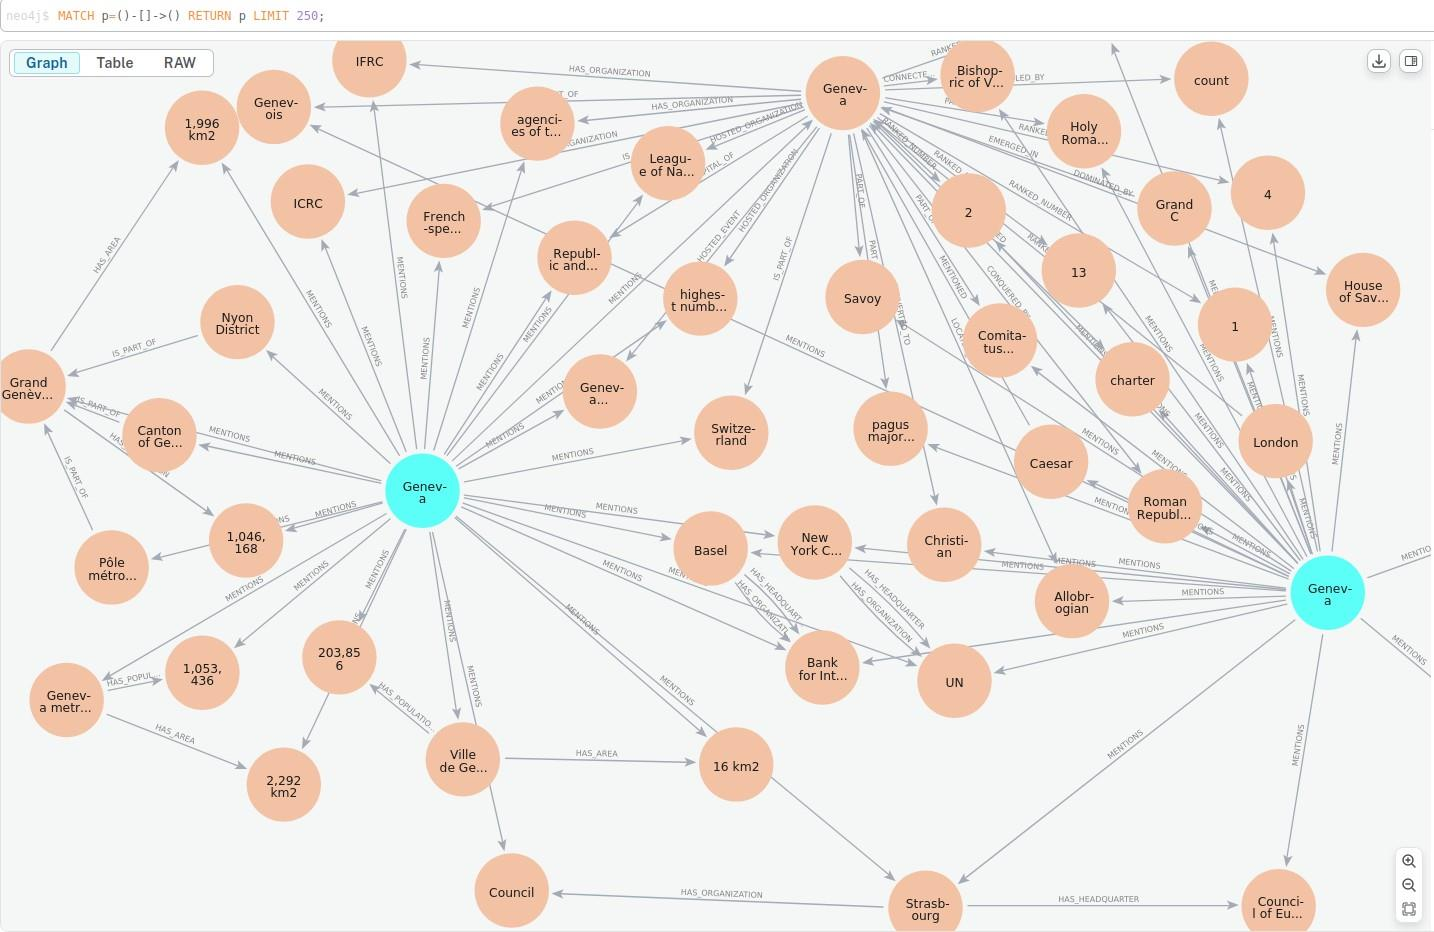